# 0. 들어가며

🌎 국정 모니터링지표를 알려주는 [e-나라지표](https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=2455)의 10대 수출입 품목 중 1996년부터 2020년까지의 수입품목 **가장 많은 횟수동안 1위인 품목은 "원유"**입니다.

- (원유 22회, 반도체 3회)

➡️ 🛢 수년간 우리나라의 수입품목의 큰 비중을 차지하는 원유의 가격을 예측하고, 미국과 한국에서 거래되는 유가 관련 주식가격의 추세가 비슷한지 알아보고자 합니다.

In [2]:
# 코랩일때 실행함
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/codestates/section4 project/e나라지표_수입현황.xls")
data.head()

,통계표명:,10대 수입품목,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50
0,단위:,백만불,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1996,NaN,1997,NaN,1998,NaN,1999,NaN,2000,NaN,2001,NaN,2002,NaN,2003,NaN,2004,NaN,2005,NaN,2006,NaN,2007,NaN,2008,NaN,2009,NaN,2010,NaN,2011,NaN,2012,NaN,2013,NaN,2014,NaN,2015,NaN,2016,NaN,2017,NaN,2018,NaN,2019,NaN,2020,NaN
2,NaN,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액,품목명,금액
3,1위,원유,"14,432",원유,"17,772",반도체,"12,244",반도체,"16,059",원유,"25,216",원유,"21,368",원유,"19,200",원유,"23,082",원유,"29,917",원유,"42,606",원유,"55,959",원유,"60,324",원유,"85,855",원유,"50,757",원유,"68,662",원유,"100,806",원유,"108,298",원유,"99,333",원유,"94,907",원유,"55,120",원유,"44,295",원유,"59,603",원유,"80,393",원유,"70,252",반도체,"50,283"
4,2위,반도체,"10,524",반도체,"12,877",원유,"11,241",원유,"14,783",반도체,"19,923",반도체,"15,547",반도체,"17,476",반도체,"21,328",반도체,"23,618",반도체,"25,133",반도체,"26,382",반도체,"25,329",반도체,"32,018",반도체,"26,619",반도체,"32,081",반도체,"32,483",반도체,"32,242",반도체,"34,619",반도체,"36,399",반도체,"38,203",반도체,"36,557",반도체,"41,177",반도체,"44,728",반도체,"47,032",원유,"44,456"


In [4]:
new_col = ['순위']
for year in range(1996, 2021):
    new_col.append(f'{year}년')
    new_col.append('가격')
print(new_col)

['순위', '1996년', '가격', '1997년', '가격', '1998년', '가격', '1999년', '가격', '2000년', '가격', '2001년', '가격', '2002년', '가격', '2003년', '가격', '2004년', '가격', '2005년', '가격', '2006년', '가격', '2007년', '가격', '2008년', '가격', '2009년', '가격', '2010년', '가격', '2011년', '가격', '2012년', '가격', '2013년', '가격', '2014년', '가격', '2015년', '가격', '2016년', '가격', '2017년', '가격', '2018년', '가격', '2019년', '가격', '2020년', '가격']


In [5]:
data.columns = new_col

In [6]:
rank_1 = data.iloc[3:4,:]
rank_1

,순위,1996년,가격,1997년,가격,1998년,가격,1999년,가격,2000년,가격,2001년,가격,2002년,가격,2003년,가격,2004년,가격,2005년,가격,2006년,가격,2007년,가격,2008년,가격,2009년,가격,2010년,가격,2011년,가격,2012년,가격,2013년,가격,2014년,가격,2015년,가격,2016년,가격,2017년,가격,2018년,가격,2019년,가격,2020년,가격
3,1위,원유,"14,432",원유,"17,772",반도체,"12,244",반도체,"16,059",원유,"25,216",원유,"21,368",원유,"19,200",원유,"23,082",원유,"29,917",원유,"42,606",원유,"55,959",원유,"60,324",원유,"85,855",원유,"50,757",원유,"68,662",원유,"100,806",원유,"108,298",원유,"99,333",원유,"94,907",원유,"55,120",원유,"44,295",원유,"59,603",원유,"80,393",원유,"70,252",반도체,"50,283"


In [9]:
rank_1.T.head(10)

,3
순위,1위
1996년,원유
가격,"14,432"
1997년,원유
가격,"17,772"
1998년,반도체
가격,"12,244"
1999년,반도체
가격,"16,059"
2000년,원유


In [13]:
rank_1.T.value_counts()[:2]

3  
원유     22
반도체     3
dtype: int64



🙏 데이터 출처
* [e-나라지표 10대 수출입 품목](https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=2455)
* [yahoo finance - wti](https://finance.yahoo.com/quote/WTI?p=WTI&.tsrc=fin-srch)
* [investing.com - 미래에셋 TIGER 원유선물 특별자산상장지수투자신탁(원유-파생형) (130680)
](https://kr.investing.com/etfs/miraeasset-tiger-wti-futures)

# set

In [14]:
# analysis
import pandas as pd
import numpy as np

# model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

# Visualization
import matplotlib.pyplot as plt

In [15]:
# 경고 뜨는 것 방지
import warnings
warnings.filterwarnings("ignore")

In [16]:
# pandas 포멧팅을 사용 : 판다스 객체들의 결과에서 쉼표를 넣고 소숫점 아래는 생략하도록 설정
# float 형식 소숫점 2자리, 쉼표 포함
pd.set_option('display.float_format', '{:,.2f}'.format)

# 1. 미국 유가 ETF WTI

## 1. Load Dataset

### 📎 데이터 살펴보기

In [79]:
wti = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/codestates/section4 project/WTI.csv')
wti.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-10,21.64,22.00,21.41,21.59,18.98,322000
1,2012-01-11,21.49,21.60,20.83,21.03,18.49,299900
2,2012-01-12,21.20,21.33,20.95,20.97,18.44,249400
3,2012-01-13,20.69,20.86,19.89,20.24,17.79,455500
4,2012-01-17,20.53,20.70,19.92,20.49,18.01,436800


In [80]:
wti.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2512,2022-01-03,3.26,3.54,3.24,3.51,3.51,3202100
2513,2022-01-04,3.57,3.67,3.55,3.61,3.61,1609300
2514,2022-01-05,3.67,3.75,3.48,3.48,3.48,1822600
2515,2022-01-06,3.62,3.72,3.52,3.68,3.68,2023100
2516,2022-01-07,3.70,3.71,3.59,3.63,3.63,1069100


In [19]:
wti.shape

(2517, 7)

In [20]:
wti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2517 non-null   object 
 1   Open       2517 non-null   float64
 2   High       2517 non-null   float64
 3   Low        2517 non-null   float64
 4   Close      2517 non-null   float64
 5   Adj Close  2517 non-null   float64
 6   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


In [21]:
wti.describe()

,Open,High,Low,Close,Adj Close,Volume
count,"2,517.00","2,517.00","2,517.00","2,517.00","2,517.00","2,517.00"
mean,7.42,7.59,7.23,7.40,7.07,"2,134,449.58"
std,6.08,6.17,5.97,6.07,5.51,"2,069,943.73"
min,1.15,1.22,1.07,1.09,1.09,"113,900.00"
25%,2.81,2.89,2.73,2.80,2.80,"815,500.00"
50%,4.57,4.68,4.43,4.55,4.55,"1,653,200.00"
75%,13.79,14.06,13.49,13.77,12.94,"2,749,500.00"
max,26.59,27.40,25.94,26.83,23.59,"40,429,700.00"


In [22]:
# describe
wti.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,2517,2517,2021-09-30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,"2,517.00",NaN,NaN,NaN,7.42,6.08,1.15,2.81,4.57,13.79,26.59
High,"2,517.00",NaN,NaN,NaN,7.59,6.17,1.22,2.89,4.68,14.06,27.40
Low,"2,517.00",NaN,NaN,NaN,7.23,5.97,1.07,2.73,4.43,13.49,25.94
Close,"2,517.00",NaN,NaN,NaN,7.40,6.07,1.09,2.80,4.55,13.77,26.83
Adj Close,"2,517.00",NaN,NaN,NaN,7.07,5.51,1.09,2.80,4.55,12.94,23.59
Volume,"2,517.00",NaN,NaN,NaN,"2,134,449.58","2,069,943.73","113,900.00","815,500.00","1,653,200.00","2,749,500.00","40,429,700.00"


In [23]:
# 컬럼 살펴보기
wti_col = wti.columns
print("wti features 개수:",len(wti_col))
print(wti_col)

wti features 개수: 7
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


### 📎 결측값 확인

In [24]:
# 결측치의 합계 정렬 : 결측치 없음!
wti.isna().sum().sort_values()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 📎 중복값 확인

In [25]:
# 중복값 확인 : 없음!
wti.duplicated().sum()

0

## 2. Create Windows

LSTM의 기본개념
* 이전 데이터 정보 일부를 다음 분석에 넘겨주는 알고리즘
* 최근 'window_size'일 간의 데이터를 보고 내일 것을 예측한다.
* window_size = 50 이라하면, 50개를 보고 1개를 예측한다는 의미

window
* window안에 들어가는 데이터는 51개
* 51개 안에서 50개를 보고 1개를 예측한다
* 그 다음 window는 한칸씩 밀면서 동일하게 한다

In [81]:
# target : 종가
close_prices_w = wti['Close'].values

In [82]:
seq_len = 50 # window_size
sequence_length = seq_len + 1 # 예측할 하나까지 추가해서 총 51개

# result안에 리스트에 51개씩 저장
result_w = []
for index in range(len(close_prices_w) - sequence_length):
    result_w.append(close_prices_w[index: index + sequence_length])

## 3. Normalize Data

모델의 성능을 높이기 위해 정규화
* 첫 50개를 담은 데이터 박스를 0으로 만들어 기준을 잡고(자기 자신을 자기자신으로 나누고 1을 빼면 0)
* 모든 윈도우를 돌면서 정규화

In [83]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result_w = normalize_windows(result_w)

## 4. split train and test data

In [84]:
# split train_w and test data
row = int(round(result_w.shape[0] * 0.9))
train_w = result_w[:row, :]
# 훈련의 강도를 높이기 위해, train_w set을 셔플해준다
np.random.shuffle(train_w)

# 51개 중 50개 훈련(X_train_w), 1개 예측(y_train)
x_train_w = train_w[:, :-1] # 50개
x_train_w = np.reshape(x_train_w, (x_train_w.shape[0], x_train_w.shape[1], 1))
y_train_w = train_w[:, -1] # 1개

x_test_w = result_w[row:, :-1] # 50개
x_test_w = np.reshape(x_test_w, (x_test_w.shape[0], x_test_w.shape[1], 1))
y_test_w = result_w[row:, -1] # 1개

x_train_w.shape, x_test_w.shape
# 2219일의 데이터를 가지고 학습해서, 247의 가격을 예측한다는 의미!

((2219, 50, 1), (247, 50, 1))

In [85]:
print(result_w)

[[ 0.         -0.02392817 -0.07577259 ... -0.29162509 -0.28464603
  -0.29511462]
 [ 0.          0.00462963  0.         ... -0.1712963  -0.14814815
  -0.09259259]
 [ 0.         -0.02760736 -0.00306748 ... -0.06441718 -0.07668712
  -0.10736196]
 ...
 [ 0.         -0.00428266 -0.00642398 ... -0.30835118 -0.248394
  -0.22698073]
 [ 0.         -0.00215054 -0.08172043 ... -0.24516129 -0.22365591
  -0.2516129 ]
 [ 0.         -0.07974138 -0.08836207 ... -0.22198276 -0.25
  -0.20689655]]


## 5. Build a Model & Training

In [31]:
# Sequential : 모델을 순차적으로 정의하는 클래스
model = Sequential()

# 중간 유닛 50,64는 수정하면서 모델 성능 보기!
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

# 손실함수 : Mean Squared Error
model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [86]:
# batch_size : 한번에 몇개씩 묶어서 학습시킬 것인지
# epochs : 반복횟수
# validation_data = test_data 옵션을 사용한다고해서 모델이 test를 학습하는 것이 아님
model.fit(x_train_w, y_train_w,
    validation_data=(x_test_w, y_test_w),
    batch_size=10,
    epochs=20)

Epoch 1/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 2/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 3/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 4/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 5/20
222/222 [==============================] - 6s 26ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 6/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 7/20
222/222 [==============================] - 6s 26ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 8/20
222/222 [==============================] - 6s 26ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 9/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 10/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0022 - val_lo

## 6. Evaluation

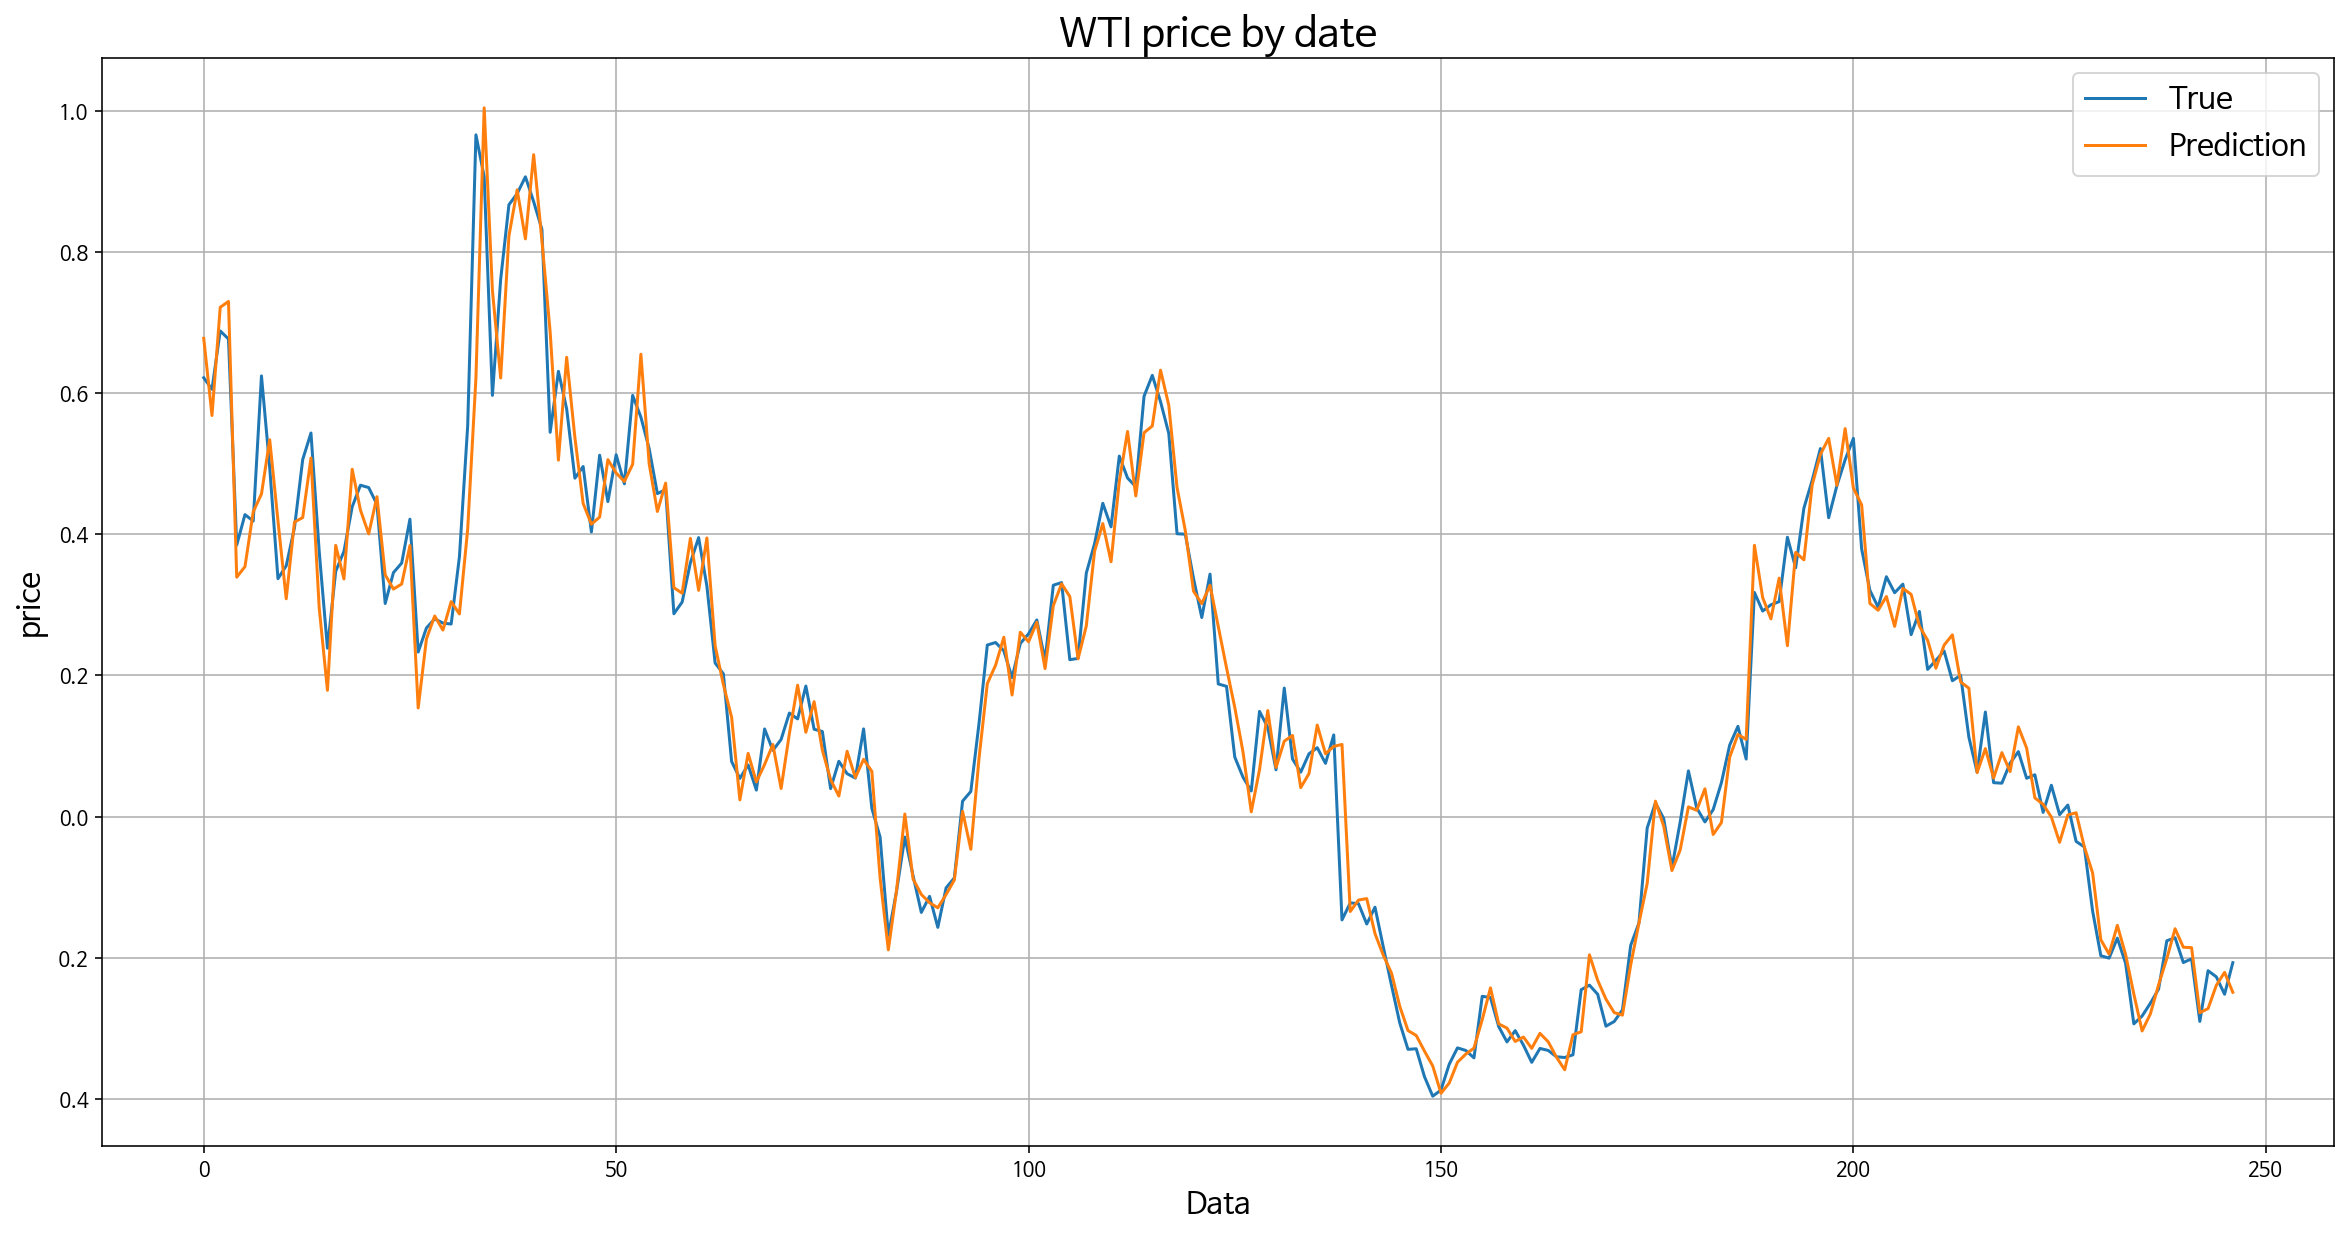

In [87]:
# blue : 실제 데이터, orange : 예측 데이터
# x축 : 날짜, y축 : 주식 가격
pred_w = model.predict(x_test_w)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)

# 범례 추가
ax.plot(y_test_w, label='True')
ax.plot(pred_w, label='Prediction')
ax.legend(fontsize = 15, loc = 'upper right')

# 그리드
plt.grid(True)

# 글자 크기 변경
plt.title('WTI price by date', fontsize=20)
plt.xlabel(xlabel='Data', fontsize = 15);
plt.ylabel(ylabel='price',fontsize = 15);

plt.show()

In [88]:
# 가격예측 회귀 -> mse 
from sklearn.metrics import mean_squared_error
pred = model.predict(x_test_w)
np.sqrt(mean_squared_error(y_test_w, pred_w))

0.05440521037013731

# 2. 한국 유가 관련 미래에셋 TIGER ETF 원유선물(130680)

## 1. Load Dataset

In [35]:
tiger = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/codestates/section4 project/130680 역사적 자료(20120101_20220108).csv")
tiger

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2022년 01월 07일,"3,755","3,710","3,760","3,710",470.11K,3.73%
1,2022년 01월 06일,"3,620","3,625","3,645","3,605",159.03K,0.00%
2,2022년 01월 05일,"3,620","3,630","3,640","3,610",85.66K,1.12%
3,2022년 01월 04일,"3,580","3,580","3,605","3,570",131.75K,0.28%
4,2022년 01월 03일,"3,570","3,570","3,575","3,545",123.10K,-0.70%
...,...,...,...,...,...,...,...
2237,2013년 03월 05일,"9,355","9,425","9,425","9,340",12.95K,-1.01%
2238,2013년 03월 04일,"9,450","9,645","9,645","9,355",25.23K,-2.48%
2239,2013년 02월 28일,"9,690","9,650","9,700","9,600",4.80K,0.99%
2240,2013년 02월 27일,"9,595","9,530","9,595","9,520",8.58K,0.16%


### 📎 데이터 살펴보기

In [36]:
tiger.tail()

,날짜,종가,오픈,고가,저가,거래량,변동 %
2237,2013년 03월 05일,"9,355","9,425","9,425","9,340",12.95K,-1.01%
2238,2013년 03월 04일,"9,450","9,645","9,645","9,355",25.23K,-2.48%
2239,2013년 02월 28일,"9,690","9,650","9,700","9,600",4.80K,0.99%
2240,2013년 02월 27일,"9,595","9,530","9,595","9,520",8.58K,0.16%
2241,2013년 02월 26일,"9,580","9,690","9,690","9,515",9.49K,-0.42%


In [37]:
tiger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242 entries, 0 to 2241
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      2242 non-null   object
 1   종가      2242 non-null   object
 2   오픈      2242 non-null   object
 3   고가      2242 non-null   object
 4   저가      2242 non-null   object
 5   거래량     2242 non-null   object
 6   변동 %    2242 non-null   object
dtypes: object(7)
memory usage: 122.7+ KB


In [38]:
tiger.shape

(2242, 7)

In [39]:
# describe
tiger.describe(include='all').T

,count,unique,top,freq
날짜,2242,2242,2021년 11월 08일,1
종가,2242,961,"4,045",15
오픈,2242,929,"4,090",12
고가,2242,942,"4,220",12
저가,2242,932,"4,090",12
거래량,2242,1954,-,39
변동 %,2242,710,0.00%,135


In [40]:
# 컬럼 살펴보기
tiger_col = tiger.columns
print("tiger features 개수:",len(tiger_col))
print(tiger_col)

tiger features 개수: 7
Index(['날짜', '종가', '오픈', '고가', '저가', '거래량', '변동 %'], dtype='object')


### 📎 결측값 확인

In [41]:
# 결측치의 합계 정렬 : 결측치 없음!
tiger.isna().sum().sort_values()

날짜      0
종가      0
오픈      0
고가      0
저가      0
거래량     0
변동 %    0
dtype: int64

### 📎 중복값 확인

In [42]:
# 중복값 확인 : 없음!
tiger.duplicated().sum()

0

### 📎 컬럼 데이터타입 변경

In [43]:
tiger.dtypes

날짜      object
종가      object
오픈      object
고가      object
저가      object
거래량     object
변동 %    object
dtype: object

In [44]:
# , 문자 제거
tiger["종가"] = tiger["종가"].str.replace(pat=r'[^\w]', repl=r'', regex=True)
tiger["오픈"] = tiger["오픈"].str.replace(pat=r'[^\w]', repl=r'', regex=True)
tiger["고가"] = tiger["고가"].str.replace(pat=r'[^\w]', repl=r'', regex=True)
tiger["저가"] = tiger["저가"].str.replace(pat=r'[^\w]', repl=r'', regex=True)

In [45]:
#거래량의 단위 K인, 변동 % 문자 제거 & numerical type으로 변경
def to_numeric(string):
    if string[-1] == 'K':
        string = float(string.replace('K',''))

    elif string[-1] == 'M':
        string = float(string.replace('M',''))

    elif string[-1] == '%':
        string = float(string.replace('%',''))

    return string

# volume_col=tiger.columns[-2:]
volume_col=tiger.columns

for column in volume_col:
    tiger[column]=tiger[column].apply(to_numeric)

In [46]:
# float로 변경
tiger =tiger.astype({'종가':'float'})
tiger =tiger.astype({'오픈':'float'})
tiger =tiger.astype({'고가':'float'})
tiger =tiger.astype({'저가':'float'})
tiger =tiger.astype({'변동 %':'float'})

In [47]:
# 날짜의 년, 월, 일 문자 제거
def remove_string(string):
    string = string.replace('년','')
    string = string.replace('월','')
    string = string.replace('일','')
    string = string.replace(' ','-')

    return string

tiger['날짜']=tiger['날짜'].apply(remove_string)
tiger.dtypes

날짜       object
종가      float64
오픈      float64
고가      float64
저가      float64
거래량      object
변동 %    float64
dtype: object

In [48]:
tiger

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2022-01-07,"3,755.00","3,710.00","3,760.00","3,710.00",470.11,3.73
1,2022-01-06,"3,620.00","3,625.00","3,645.00","3,605.00",159.03,0.00
2,2022-01-05,"3,620.00","3,630.00","3,640.00","3,610.00",85.66,1.12
3,2022-01-04,"3,580.00","3,580.00","3,605.00","3,570.00",131.75,0.28
4,2022-01-03,"3,570.00","3,570.00","3,575.00","3,545.00",123.10,-0.70
...,...,...,...,...,...,...,...
2237,2013-03-05,"9,355.00","9,425.00","9,425.00","9,340.00",12.95,-1.01
2238,2013-03-04,"9,450.00","9,645.00","9,645.00","9,355.00",25.23,-2.48
2239,2013-02-28,"9,690.00","9,650.00","9,700.00","9,600.00",4.80,0.99
2240,2013-02-27,"9,595.00","9,530.00","9,595.00","9,520.00",8.58,0.16


In [49]:
tiger.dtypes

날짜       object
종가      float64
오픈      float64
고가      float64
저가      float64
거래량      object
변동 %    float64
dtype: object

## 2. Create Windows

In [50]:
# target : 종가
close_prices = tiger['종가'].values

In [51]:
seq_len = 50 # window_size
sequence_length = seq_len + 1 # 예측할 하나까지 추가해서 총 51개

# result안에 리스트에 51개씩 저장
result = []
for index in range(len(close_prices) - sequence_length):
    result.append(close_prices[index: index + sequence_length])

## 3. Normalize Data

In [52]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result)

## 4. split train and test data

In [53]:
# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
# 훈련의 강도를 높이기 위해, train set을 셔플해준다
np.random.shuffle(train)

# 51개 중 50개 훈련(X_train), 1개 예측(y_train)
x_train = train[:, :-1] # 50개
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1] # 1개

x_test = result[row:, :-1] # 50개
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1] # 1개

x_train.shape, x_test.shape
# 1972 데이터를 가지고 학습해서, 219 가격을 예측한다는 의미!

((1972, 50, 1), (219, 50, 1))

In [54]:
result

array([[ 0.        ,  0.01433121, -0.00796178, ..., -0.13375796,
        -0.12101911, -0.11305732],
       [ 0.        ,  0.00265604,  0.03585657, ..., -0.15405046,
        -0.16334661, -0.16069057],
       [ 0.        , -0.00721154, -0.00961538, ...,  0.11538462,
         0.10697115,  0.12379808],
       ...,
       [ 0.        , -0.00102041,  0.00408163, ..., -0.04081633,
        -0.04540816, -0.03571429],
       [ 0.        ,  0.00510725,  0.0081716 , ..., -0.04443309,
        -0.03472932, -0.0102145 ],
       [ 0.        ,  0.00304878, -0.00304878, ..., -0.03963415,
        -0.0152439 , -0.02489837]])

## 5. Build a Model & Training

In [55]:
# Sequential : 모델을 순차적으로 정의하는 클래스
model = Sequential()

# 중간 유닛 50,64는 수정하면서 모델 성능 보기!
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

# 손실함수 : Mean Squared Error
model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [56]:
# batch_size : 한번에 몇개씩 묶어서 학습시킬 것인지
# epochs : 반복횟수
# validation_data = test_data 옵션을 사용한다고해서 모델이 test를 학습하는 것이 아님
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
198/198 [==============================] - 10s 31ms/step - loss: 0.0060 - val_loss: 5.7338e-04
Epoch 2/20
198/198 [==============================] - 5s 26ms/step - loss: 0.0023 - val_loss: 3.9520e-04
Epoch 3/20
198/198 [==============================] - 5s 26ms/step - loss: 0.0019 - val_loss: 3.7622e-04
Epoch 4/20
198/198 [==============================] - 5s 26ms/step - loss: 0.0015 - val_loss: 5.2681e-04
Epoch 5/20
198/198 [==============================] - 5s 26ms/step - loss: 0.0012 - val_loss: 2.5994e-04
Epoch 6/20
198/198 [==============================] - 5s 26ms/step - loss: 0.0011 - val_loss: 2.0259e-04
Epoch 7/20
198/198 [==============================] - 5s 26ms/step - loss: 0.0010 - val_loss: 2.6253e-04
Epoch 8/20
198/198 [==============================] - 5s 26ms/step - loss: 8.3113e-04 - val_loss: 8.4905e-04
Epoch 9/20
198/198 [==============================] - 5s 26ms/step - loss: 8.4362e-04 - val_loss: 6.3295e-04
Epoch 10/20
198/198 [=========================

## 6. Evaluation

In [57]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

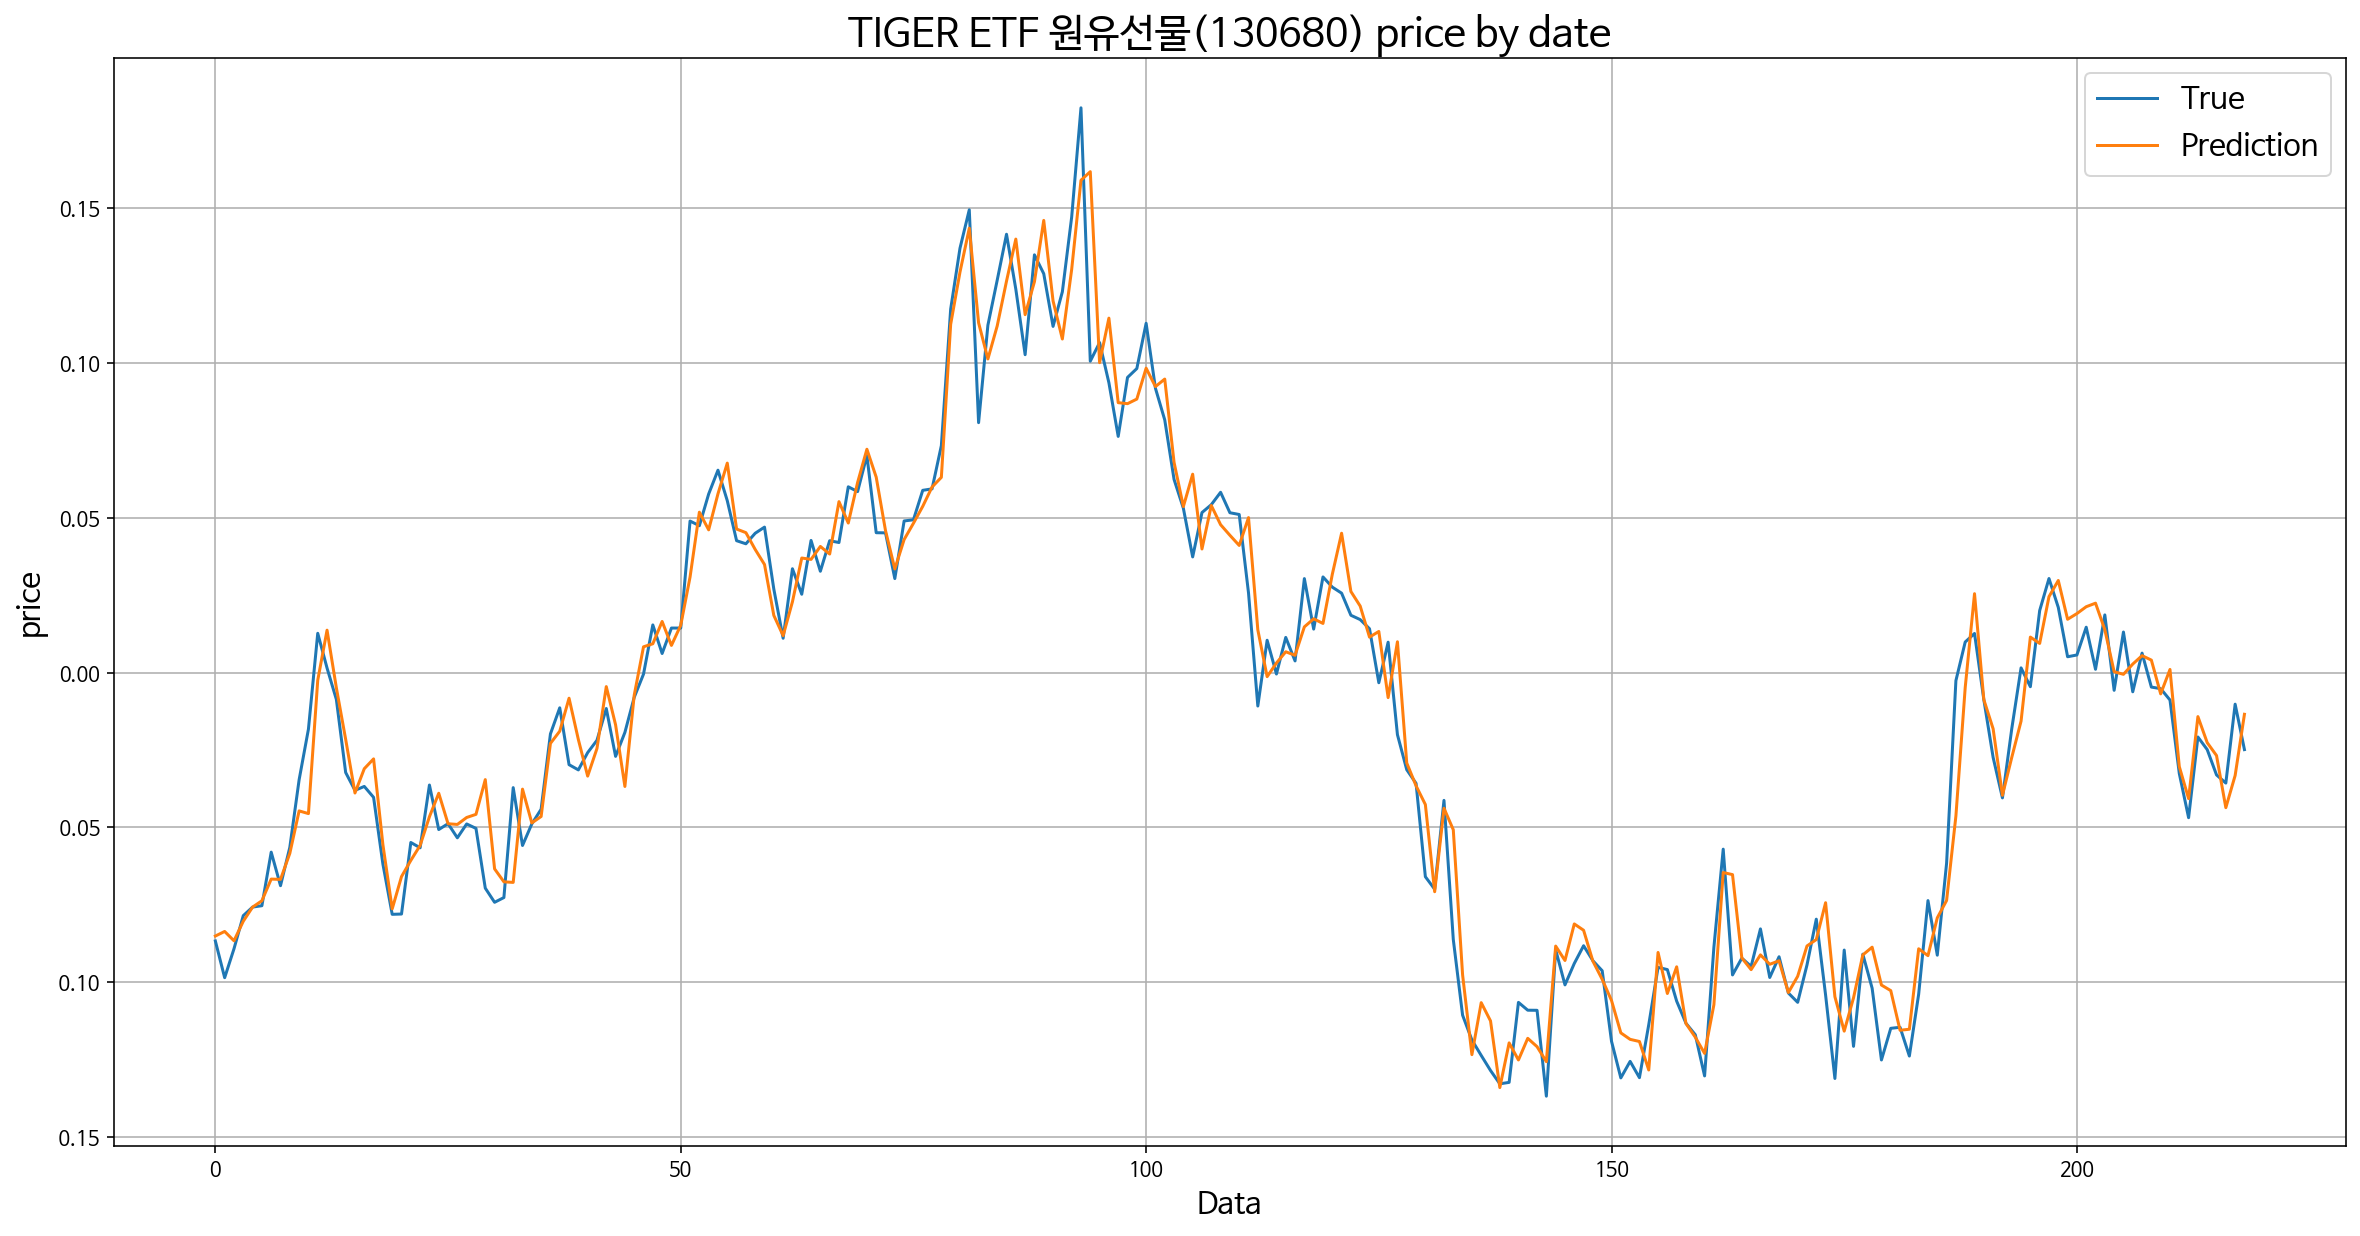

In [58]:
# blue : 실제 데이터, orange : 예측 데이터
# x축 : 날짜, y축 : 주식 가격
pred = model.predict(x_test)
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)

# 범례 추가
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend(fontsize = 15, loc = 'upper right')

# 그리드
plt.grid(True)

# 글자 크기 변경
plt.title('TIGER ETF 원유선물(130680) price by date', fontsize=20)
plt.xlabel(xlabel='Data', fontsize = 15);
plt.ylabel(ylabel='price',fontsize = 15);

plt.show()

In [91]:
# 가격예측 회귀 -> mse 
from sklearn.metrics import mean_squared_error
pred = model.predict(x_test)
np.sqrt(mean_squared_error(y_test, pred))

0.013286794522043595

# 3. 한계
* 오로지 단순하게 주식 데이터로만 예측을 하다보니, 증권가의 뉴스, 정책 변경, 제품의 판매량, 사회적인 정세 등의 외부적인 영향을 반영하지 못함

* 그래프를 자세히 보면 학습을 해서 미래의 주가를 예측을 한다기보다는, 실제 데이터(True)가 먼저 움직이고 미세하게 예측 데이터(orange)가 따라가고 있음(주가 따라가기)

### 🥲 향후 개선 방향
* 관련 뉴스를 크롤링하여 감성 분석등을 통해 새로운 컬럼을 추가해주면 정확성이 개선될 것 같음
* attention 모델로 예측 및 분석 시도해보고 싶음

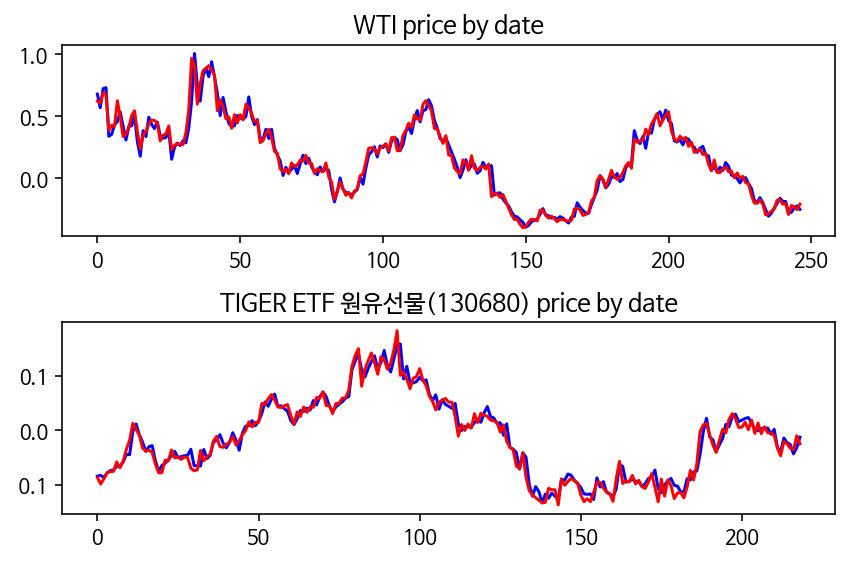

In [92]:
# WTI와 국내 원유 선물 가격 차트 한번에 시각화

plt.subplot(2, 1, 1) #2행,1열,중 1번째 위치
plt.plot(pred_w, 'b', y_test_w, 'r')
plt.title('WTI price by date')

plt.subplot(2, 1, 2) #2행,1열,중 2번째 위치
plt.plot(pred, 'b', y_test, 'r')
plt.title('TIGER ETF 원유선물(130680) price by date')
plt.tight_layout()